In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from bcg_code import *

from IPython.display import clear_output

In [2]:
experiments = []


# synthetic example with k outlying eigenvalues and block size 2k
Λ = np.load('matrices/fastdecay.npy')
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

l = 22
experiments.append({'name':'fastdecay', 'Λ':Λ, 'b':b, 'ts':np.arange(151,dtype='int'), 'reorth':False, 'l':l, 'μs':[0]})


# Λ = np.load('matrices/nos7.npy')
# d = len(Λ)
# b = np.ones(d)/np.sqrt(d)

# l = 1
# experiments.append({'name':'nos7', 'Λ':Λ, 'b':b, 'ts':np.arange(250,dtype='int'), 'reorth':False, 'l':l, 'μs':[0]})


# Λ = np.load('matrices/raefsky4.npy')+1
# d = len(Λ)
# b = np.ones(d)/np.sqrt(d)

# l = 10
# experiments.append({'name':'raefsky4', 'Λ':Λ, 'b':b, 'ts':np.arange(250,dtype='int'), 'reorth':False, 'l':l, 'μs':[0]})


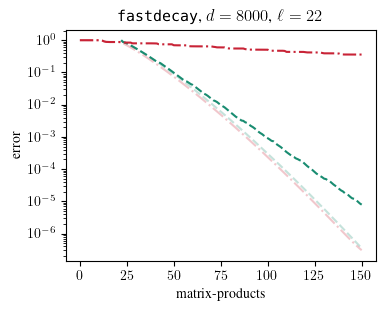

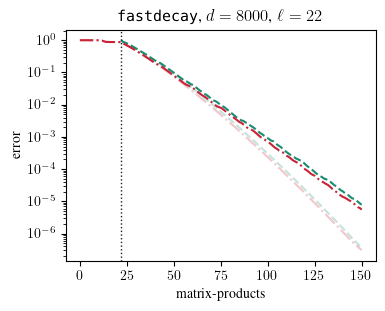

In [3]:
for experiment in experiments:

    name = experiment['name']
    Λ = experiment['Λ']
    b = experiment['b']
    ts = experiment['ts']
    reorth = experiment['reorth']
    l = experiment['l']
    μs = experiment['μs']

    d = len(Λ)
    A = sp.sparse.spdiags(Λ.reshape(1,d),[0])
    x_true = np.diag(1/Λ)@b

    μ = μs[0]
    x_true = (1/(Λ+μ))*b

    reorth = False
    
    # CG
    x_CG = get_BCG_sols(A,b.reshape(d,1),ts,μs,reorth=reorth)
    err_CG = np.full(len(ts),np.nan)
    for i,t in enumerate(ts):
        e = x_true-x_CG[i,0]
        err_CG[i] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)

        
    # nystrom PCG
    ss = [1,3]
    np.random.seed(0)
    Ω = np.random.randn(d,l)

    err_PCG = np.full((len(ts),len(ss)),np.nan)
    for si,s in enumerate(ss):
        U,D = nystrom(A,Ω,s)
    
        Aμ = A + μ*sp.sparse.eye(d)
        Pμ = deflation_precond12(U,D,D[-1],μ)
    
        x_PCG = get_PCG_sols(Aμ,b.reshape(d,1),Pμ,ts,reorth=reorth)
        for i,t in enumerate(ts):
            e = x_true-x_PCG[i]
            err_PCG[i,si] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)

    reorth = True
    # CG
    x_CG_ro = get_BCG_sols(A,b.reshape(d,1),ts,μs,reorth=reorth)
    err_CG_ro = np.full(len(ts),np.nan)
    for i,t in enumerate(ts):
        e = x_true-x_CG_ro[i,0]
        err_CG_ro[i] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)

    
    err_CG_pro = np.full((len(ts),len(ss)),np.nan)
    for si,s in enumerate(ss):
        reorth_max = l*s
        x_CG_pro = get_BCG_sols(A,b.reshape(d,1),ts,μs,reorth=reorth,reorth_max=reorth_max)
        for i,t in enumerate(ts):
            e = x_true-x_CG_pro[i,0]
            err_CG_pro[i,si] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)


    # nystrom PCG
    np.random.seed(0)
    Ω = np.random.randn(d,l)

    err_PCG_ro = np.full((len(ts),len(ss)),np.nan)
    for si,s in enumerate(ss):
        U,D = nystrom(A,Ω,s)
    
        Aμ = A + μ*sp.sparse.eye(d)
        Pμ = deflation_precond12(U,D,D[-1],μ)
    
        x_PCG_ro = get_PCG_sols(Aμ,b.reshape(d,1),Pμ,ts,reorth=reorth)
        for i,t in enumerate(ts):
            e = x_true-x_PCG_ro[i]
            err_PCG_ro[i,si] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)

       

    fig,ax = plt.subplots(1,1,figsize=(4,3))

    si=0; s = ss[si]
    mask = ts <= max(ts)-s*l
    plt.plot(ts[mask]+s*l,err_PCG[mask,si],ls='--',color=c3,label=f'PCG ($s={s}$)')
    plt.plot(ts[mask]+s*l,err_PCG_ro[mask,si],ls='--',color=c3,alpha=.25)

    
    plt.plot(ts,err_CG,ls='-.',color=c2) 
    plt.plot(ts,err_CG_ro,ls='-.',color=c2,alpha=.25)

    
    plt.title(f'\\texttt{{{name}}}, $d={d}$, $\ell = {l}$')
    plt.ylabel('error')
    plt.xlabel(f'matrix-products')
    
    plt.yscale('log')

    plt.savefig(f"imgs/iter_error_{name}_l{l}_fpcompare.pdf",bbox_inches='tight')

    

    fig,ax = plt.subplots(1,1,figsize=(4,3))

    si=0; s = ss[si]
    mask = ts <= max(ts)-s*l
    plt.plot(ts[mask]+s*l,err_PCG[mask,si],ls='--',color=c3,label=f'PCG ($s={s}$)')
    plt.plot(ts[mask]+s*l,err_PCG_ro[mask,si],ls='--',color=c3,alpha=.25)
    
    plt.plot(ts,err_CG_pro[:,si],ls='-.',color=c2)
    plt.axvline(s*l,color=c0,ls=':',lw=1)


    plt.plot(ts,err_CG_ro,ls='-.',color=c2,alpha=.25)

    
    plt.title(f'\\texttt{{{name}}}, $d={d}$, $\ell = {l}$')
    plt.ylabel('error')
    plt.xlabel(f'matrix-products')
    
    plt.yscale('log')

    plt.savefig(f"imgs/iter_error_{name}_l{l}_fpcompare_pro.pdf",bbox_inches='tight')

    # plt.close()